#  Demo file: RI confidence intervals

In [1]:
%show_gui

In [2]:
//  Some preliminaries for stata
clear all
set seed 12345
set matsize 11000
set scheme s1mono

//  Add /ado/ subdirectory to top of Stata's search path.
//  Assume we are EITHER in the root of the github repo OR in the /demo/ folder to begin.
if regexm("`c(pwd)'","demo") local pwd = subinstr(subinstr("`c(pwd)'","\","/",.),"/demo", "", 1)
else local pwd "`c(pwd)'"
di as err "The current working directory is `pwd'"
adopath ++`pwd'/ado 








The current working directory is D:/GitHub/RI_CI

  [1]              "D:/GitHub/RI_CI/ado"
  [2]  (BASE)      "C:\Program Files (x86)\Stata15\ado\base/"
  [3]  (SITE)      "C:\Program Files (x86)\Stata15\ado\site/"
  [4]              "."
  [5]  (PERSONAL)  "c:\ado\personal/"
  [6]  (PLUS)      "c:\ado\plus/"
  [7]  (OLDPLACE)  "c:\ado/"
  [8]              "C:\Programs\Anaconda3\Lib\site-packages\stata_kernel\ado"


In [3]:
// Force reload of Stata programs
capture program drop ri_estimates
capture program drop impose_tx 

##  Simulate some data

Let's generate 500 observations according to the genrative model
\begin{align}
y_0 &= e_0 \\
y_1 &= y_0 + \tau
\end{align}

with $\tau = 1$ and $e_0\sim N(0,1)$

In [4]:
set obs 500
global tau = 1
ge y0 = rnormal()
ge y1 = y0 + $tau


number of observations (_N) was 0, now 500





Let treatment assignment be by simple randomization. We need to do two things:

1. create a set of $R$ feasible randomizations, to feed into the RI machine and to feed into the DGP for observed outcomes; and 
2. generate observed outcome $y$ according to the switching regression 
    \begin{equation}
    y = y_0 + t(y_1 - y_0)
    \end{equation}

In [5]:
global R = 200

In [6]:
ge t_0 = (runiform() >= 0.5)
ge y = y0 + t_0*(y1-y0)

In [7]:
ge i = _n // an identifier for observations, used later to merge potential treatments
tempfile T0 
preserve 
keep i t_0
forvalues r=1/$R {
    ge t_`r' = (runiform() >= 0.5 )
}
save `T0'
restore 







file C:\Users\az332\AppData\Local\Temp\ST_1a88_000001.tmp saved



##  Estimate and get a p-value

In [8]:
ri_estimates, permutations($R) key(i) t1(t , filename(`T0')) teststat(t) pointestimates pvalues : regress y t
mat li r(RESULTS)
global tstat = el(r(RESULTS),rownumb(r(RESULTS),"t"),colnumb(r(RESULTS),"t"))
global pval  = el(r(RESULTS),rownumb(r(RESULTS),"t"),colnumb(r(RESULTS),"p"))
mat T0 = r(T0)
di "The t statistic is $tstat, with p-value $pval"


Point estimates, analytical SEs

      Source |       SS           df       MS      Number of obs   =       500
-------------+----------------------------------   F(1, 498)       =     73.16
       Model |  78.9447515         1  78.9447515   Prob > F        =    0.0000
    Residual |  537.343109       498  1.07900223   R-squared       =    0.1281
-------------+----------------------------------   Adj R-squared   =    0.1263
       Total |   616.28786       499  1.23504581   Root MSE        =    1.0388

------------------------------------------------------------------------------
           y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           t |   .7947317   .0929116     8.55   0.000     .6121846    .9772788
       _cons |   .1559891   .0654351     2.38   0.018     .0274262     .284552
------------------------------------------------------------------------------
file C:\Users\az3




number of observations will be reset to 200
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 200


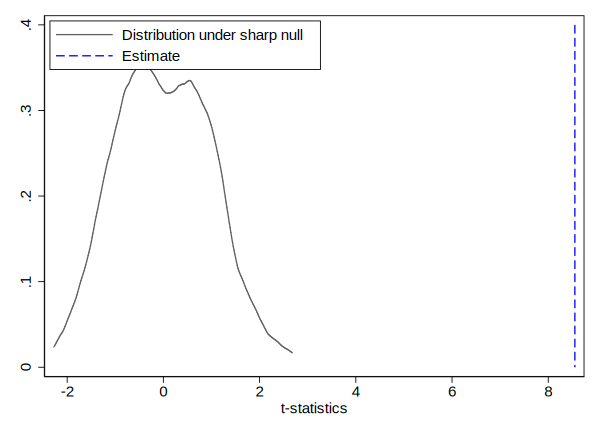

In [9]:
// Visualizing result
preserve
drop _all 
svmat T0, names(tstat)
twoway (kdensity tstat) ///
    (scatteri 0.4 $tstat 0 $tstat, recast(line) lcolor(blue) lpattern(dash)) ///
    , /// xline($tstat, lcolor(blue))  ///
    xtitle("t-statistics") /// xscale(range($tstat)) /// 
    legend(order(1 "Distribution under sharp null" 2 "Estimate") cols(1) position(11) ring(0))
restore

## Calculate CI

##  The first thing we need is a language to describe the dgp and (add or) subtract a treatment effect.

The command `impose_tx` does so, allowing us to describe the dgp using [Wilkinson-Rogers Notation](http://www.jerous.org/att/2016/05/11/wilkinson-rogers/wilkinson2formula.html).  Use the `subtract` option to take away the specified treatment effect from those treated (`treatment==1`); otherwise, default behavior will be to add it.  Specify a new variable (in the example below, `yprime`) to hold the generated variable.

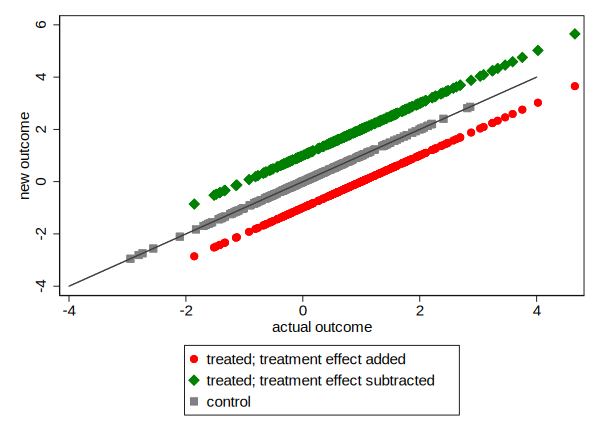

In [10]:
capture program drop impose_tx
capture drop yminus
capture drop yplus

//  Example where treatment effect is being subtracted
qui ge yminus = .
impose_tx , dgp(y ~ t_0) treatment(1) y(yminus) subtract

//  Example where treatment effect is being added
qui ge yplus = .
impose_tx, dgp(y ~ t_0) treatment(1) y(yplus)

tw (sc yminus y if t_0 == 1, mcolor(red)) ///
    (sc yplus y if t_0 == 1, mcolor(green)) ///
    (sc yminus y if t_0 == 0) ///
    (function y=x , range(-4 4)) /// (line y y, sort) ///
    , legend(order(1 "treated; treatment effect added" 2 "treated; treatment effect subtracted" 3 "control") cols(1)) ///
    ytitle("new outcome") xtitle("actual outcome")

## The second thing we need is the ability to conduct RI for non-sharp nulls.

This requires the ability to specify the data-generating process---which should be distinct from the estimator that delivers the test statistic---for randomization inference, in `ri_estimates()`.


file C:\Users\az332\AppData\Local\Temp\ST_1a88_000005.tmp saved
RI: Permutation of T1...
... done.




number of observations will be reset to 200
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 200


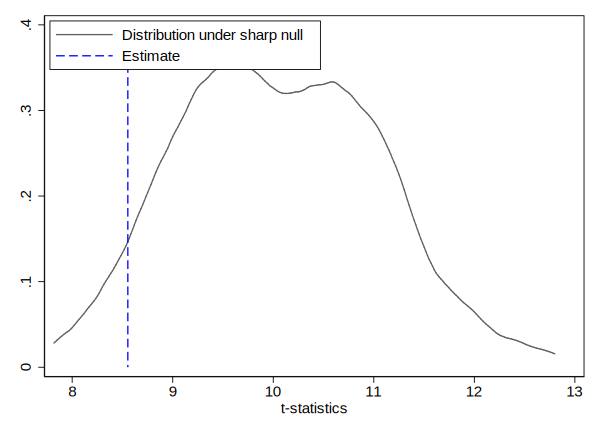

In [12]:
ri_estimates, permutations($R) key(i) t1(t , filename(`T0')) teststat(t) dgp(1) /// imposing the *truth*
    : regress y t
mat T0alt = r(T0)

// Visualizing result
preserve
drop _all 
svmat T0alt, names(tstat)
twoway (kdensity tstat) ///
    (scatteri 0.4 $tstat 0 $tstat, recast(line) lcolor(blue) lpattern(dash)) ///
    , /// xline($tstat, lcolor(blue))  ///
    xtitle("t-statistics") /// xscale(range($tstat)) /// 
    legend(order(1 "Distribution under sharp null" 2 "Estimate") cols(1) position(11) ring(0))
restore

##  The third thing we need is a way to come up with starting values for the search process for the 95% CI.

##  And the fourth thing we need is the search algorithm itself, including step size and stopping rule.